In [37]:
import numpy as np
import math
import time
from datetime import datetime, timezone
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

In [38]:
df = pd.read_csv('train_data.csv', parse_dates=['time'])


In [39]:
def check_count(X):
    unique_values, counts = np.unique(X, return_counts=True)

    # Display the counts for each unique value
    for value, count in zip(unique_values, counts):
        print(f"Value {value} appears {count} times. percentage: {round(count*100 / len(X), 2)}")
        
check_count(df['sleep'])

Value 0 appears 63266 times. percentage: 8.34
Value 1 appears 52341 times. percentage: 6.9
Value 2 appears 372379 times. percentage: 49.08
Value 3 appears 95551 times. percentage: 12.59
Value 4 appears 10533 times. percentage: 1.39
Value 5 appears 164664 times. percentage: 21.7


In [40]:
def eval(test, pred, label=""):
    # Evaluate the model
    accuracy = accuracy_score(test, pred)
    print("Accuracy:", accuracy)

    # Display classification report
    print("Classification Report:")
    print(classification_report(test, pred))
    cm = confusion_matrix(test, pred)

    #Printing the accuracy
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(label)
    plt.show()

In [41]:
def process_heart_rates(arr, n):
    arr = np.unique(arr)
    l = len(arr)
    if l >= n:
        return arr[:n]
    else:
        # Fill missing values with the mean
        mean = np.mean(arr)
        mean_arr = np.full(n - l, mean)
        return np.concatenate([arr, mean_arr])


def create_sequences(data, seq_length, hr_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        acc_x = data['x'][i : i + seq_length]
        acc_y = data['y'][i : i + seq_length]
        acc_z = data['z'][i : i + seq_length]
        
        hr = data['heart_rate'][i : i + seq_length]
        hr = process_heart_rates(hr, hr_length)
        
        seq = np.concatenate([acc_x, acc_y, acc_z, hr])
        sequences.append(seq)
    return np.array(sequences)

In [42]:
def get_XY(data, seq_length, hr_length):
    X = []
    Y = []
    for idx, (_, group_data) in enumerate(data.groupby(['ID', 'sleep'])):
        label = group_data.iloc[0]['sleep']
        
        x = create_sequences(group_data, seq_length, hr_length)
        y = np.full(len(x), label)
        if idx == 0:
            X = x
        else:
            X = np.concatenate((X, x), axis = 0)
        Y.extend(y)
    return X, Y
        
        
    

In [43]:
print(len(df))
#eval_subject_id = 759667
eval_subject_id = 781756
condition = df['ID'] == eval_subject_id

df_eval = df[condition]
df = df[~condition]


758734


In [44]:
X_eval, y_eval = get_XY(df_eval, 50, 5)
print(len(y_eval))

X, y = get_XY(df, 50, 5)
print(len(y))

29023
722116


In [45]:
n = 10**6
X_train, X_test, y_train, y_test = train_test_split(X[:n], y[:n], test_size=0.2, random_state=42)
check_count(y_train)
print('total number of train data: {}'.format(len(y_train)))

Value 0 appears 47595 times. percentage: 8.24
Value 1 appears 36350 times. percentage: 6.29
Value 2 appears 285604 times. percentage: 49.44
Value 3 appears 74904 times. percentage: 12.97
Value 4 appears 8258 times. percentage: 1.43
Value 5 appears 124981 times. percentage: 21.63
total number of train data: 577692


## Random Forest Classifier (sleep stages)

In [46]:
rf_classifier = RandomForestClassifier(random_state=42, verbose=True, n_jobs=-1)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rfc = rf_classifier.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.5s finished


Accuracy: 0.9954370464742702
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11755
           1       1.00      0.99      0.99      9157
           2       1.00      1.00      1.00     71571
           3       0.99      0.99      0.99     18536
           4       0.98      0.99      0.98      2128
           5       1.00      1.00      1.00     31277

    accuracy                           1.00    144424
   macro avg       0.99      0.99      0.99    144424
weighted avg       1.00      1.00      1.00    144424

[[11720    16    19     0     0     0]
 [   11  9034   105     0     0     7]
 [    8    20 71334   158    29    22]
 [    0     0   173 18344    19     0]
 [    2     0     0    17  2106     3]
 [    0     0    50     0     0 31227]]


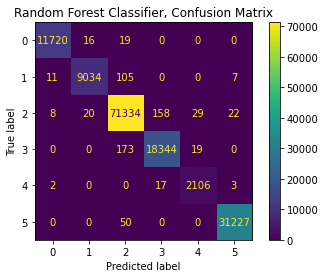

In [47]:
eval(y_test, y_pred_rfc, 'Random Forest Classifier, Confusion Matrix')

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\Users\juho\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.2545911863005203
Classification Report:
              precision    recall  f1-score   support

           0       0.08      0.33      0.13      2397
           1       0.30      0.12      0.17      5315
           2       0.42      0.38      0.40     13685
           3       0.00      0.00      0.00       641
           4       0.00      0.00      0.00         0
           5       0.17      0.11      0.13      6985

    accuracy                           0.25     29023
   macro avg       0.16      0.16      0.14     29023
weighted avg       0.30      0.25      0.26     29023

[[ 792   52 1410    1    0  142]
 [1699  640 1911    1    0 1064]
 [5227 1099 5204    3    0 2152]
 [   0  183  183    0    0  275]
 [   0    0    0    0    0    0]
 [2317  178 3645   91    1  753]]


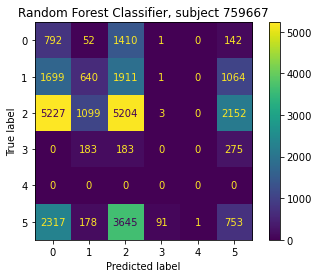

In [48]:
y_eval_pred_rfc = rf_classifier.predict(X_eval)
eval(y_eval, y_eval_pred_rfc, 'Random Forest Classifier, subject 759667')

## Support Vector Machines (sleep stages)

Does not perform very well + takes a long time

In [11]:
svm_classifier = SVC(kernel='poly', C=1.0, random_state=42, verbose=True)

svm_classifier.fit(X_train, y_train)


y_pred_svm = svm_classifier.predict(X_test)

[LibSVM]

Accuracy: 0.8265
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.87      0.77       497
           1       0.62      0.15      0.24       173
           2       0.86      0.89      0.88      1016
           3       1.00      0.91      0.96       314

    accuracy                           0.83      2000
   macro avg       0.80      0.71      0.71      2000
weighted avg       0.82      0.83      0.81      2000

[[431   0  66   0]
 [ 95  26  52   0]
 [ 91  16 909   0]
 [  0   0  27 287]]


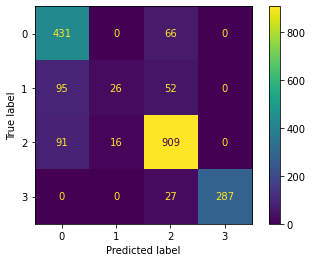

In [12]:
eval(y_test, y_pred_svm)

## MLP (sleep stages)
not the best performance either + takes forever

In [33]:
classifier = MLPClassifier(
    activation='relu',
    hidden_layer_sizes=(124,64,32),
    max_iter=200,
    alpha=0.01,
    solver='adam',
    verbose=1
)
classifier.fit(X_train, y_train)
y_pred_mlp = classifier.predict(X_test)

Iteration 1, loss = 1.22944137
Iteration 2, loss = 1.05464603
Iteration 3, loss = 0.98331229
Iteration 4, loss = 0.94214800
Iteration 5, loss = 0.91417876
Iteration 6, loss = 0.89017747
Iteration 7, loss = 0.87110465
Iteration 8, loss = 0.85268166
Iteration 9, loss = 0.83806401
Iteration 10, loss = 0.82453895
Iteration 11, loss = 0.81262517
Iteration 12, loss = 0.80036478
Iteration 13, loss = 0.79067858
Iteration 14, loss = 0.78183848
Iteration 15, loss = 0.77582844
Iteration 16, loss = 0.76753212
Iteration 17, loss = 0.76116815
Iteration 18, loss = 0.75347164
Iteration 19, loss = 0.75001426
Iteration 20, loss = 0.74533237
Iteration 21, loss = 0.73995640
Iteration 22, loss = 0.73387660
Iteration 23, loss = 0.73154194
Iteration 24, loss = 0.72479889
Iteration 25, loss = 0.72224056
Iteration 26, loss = 0.71886271
Iteration 27, loss = 0.71380019
Iteration 28, loss = 0.71151960
Iteration 29, loss = 0.70794240
Iteration 30, loss = 0.70526460
Iteration 31, loss = 0.70194176
Iteration 32, los

C:\Users\juho\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7998997058943117
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.63      0.66     12130
           1       0.50      0.36      0.42     10158
           2       0.83      0.88      0.85     73385
           3       0.84      0.77      0.80     18103
           4       0.73      0.89      0.80      2084
           5       0.82      0.84      0.83     31706

    accuracy                           0.80    147566
   macro avg       0.74      0.73      0.73    147566
weighted avg       0.79      0.80      0.79    147566

[[ 7593  1125  2065   108    17  1222]
 [ 1448  3658  3878    70     4  1100]
 [ 1094  1749 64443  2183   459  3457]
 [   56    99  3583 13943   203   219]
 [    9     8   153    37  1861    16]
 [  588   703  3655   218     2 26540]]


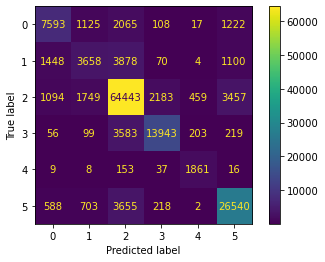

In [35]:
eval(y_test, y_pred_mlp)

## Gradient Boosting

takes forever

In [ ]:
gb_classifier = GradientBoostingClassifier(
    random_state=42,
    verbose=1,
    learning_rate=1,
    max_depth=2,
    subsample=0.8
)
gb_classifier.fit(X_train, y_train)
y_pred_gb = gb_classifier.predict(X_test)

In [ ]:
eval(y_test, y_pred_gb)